In [1]:
import numpy as np
import struct
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
import random
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from transformer.model import TransformerTimeSeries

### Automatic speach recognition with neural networks
This notebook uses MFCC pre-prossesing to generate acoustic features to the neural network, and then the neural network can be trained and tested. The baseline consists into HNNs. 

The dataset utilized in this notebook is the speach commands datasets from tensorflow. As this dataset comes with a lot of words and a lots of examples, we choose to simplify this notebook example by focusing in the following words: cat, dog, happy, house and zero. The training set consists into 25 examples of each word, and the testing set consists into 5 new examples of each word.

All the pre-prossecing is made by the spock: . Using this software the user can process WAV files and output the processed acoustic features in `.FEA` files. Then the neural network can receive this accoustic features and output the class that corresponds to the right word. 

### The first step consists into reading the FEA files

In [2]:
feat_dir = './output_100_25/mfcceda39w240s80/features'
val_dir = './output_25_5/mfcceda39w240s80/features'

In [3]:
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
def fea_to_samples(filename):
    # Discard the header with 2048 bytes that yield 512 floats
    feat_array = np.fromfile(filename, dtype='>f') [512:]
    num_of_paterns = feat_array[0]
    space_dimension = feat_array[1]
    
    res = []
    # Jump the first 2 floats
    i_s = 2
    total_frames = []
    for pat in range(int(num_of_paterns)):
        # Feature Extraction
        n_frames = feat_array[i_s]
        total_frames.append(n_frames) 
        i_e = space_dimension*n_frames + i_s + 1  
        feat = feat_array[i_s+1: int(i_e)].tolist()
        i_s = int(i_e)
        res.append(feat)
    
    assert(i_e == len(feat_array))
    
    # Convert the feature patterns to a np matrix, padding according 
    # to the biggest entry
    max_dim = max([len(row) for row in res])
    res_np = np.zeros((int(num_of_paterns), max_dim))
    
    for pat in range(int(num_of_paterns)):
        vec_len = len(res[pat])
        res_np[pat][:vec_len] = res[pat] 
    
    return res_np,(max(total_frames), space_dimension)

### After reading the FEA files we can organize the network input and desireble output
In this supervised learning probblem we must organize matrices that will serve as input or features, and other that will be the desired output or label.

In [5]:
def generate_xy_matrices(feat_dir):
    files = listdir(feat_dir)
    labels = [name[2:-4] for name in listdir(feat_dir)]
    x_matrix, shape = fea_to_samples(feat_dir+ '/' +files[0])

    y_matrix = np.zeros((x_matrix.shape[0], 1))
    y_matrix[:,0] = 0
    for file_i in range(1,len(files)):
        x_i, _ = fea_to_samples(feat_dir + '/' + files[file_i])
        y_i = np.zeros((x_i.shape[0], 1))
        y_i[:,0] = file_i
        x_matrix = np.concatenate((x_matrix, x_i))
        y_matrix = np.concatenate((y_matrix, y_i))

    return x_matrix, y_matrix, shape

### After that we must organize our dataset object
As we are using the Pytorch stack, it is recommended to use the Dataset class to organize the entry and output samples of training and test sets. 

In [6]:
class MfcSet(Dataset):
    def __init__(self,
                 x_matrix,
                 y_matrix,
                 shape,
                std_scaler=None,
                min_max_scaler=None):
        
#         if std_scaler==None:
#             # Standard scaling
#             std_scaler = StandardScaler()
#             std_scaler.fit(x_matrix)
#         x_matrix = std_scaler.transform(x_matrix)
#         print(x_matrix.shape)
       
        if min_max_scaler == None:
            # Min max scaling
            min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
            min_max_scaler.fit(x_matrix)
        x_matrix = min_max_scaler.transform(x_matrix)
        
        shape = (int(shape[0]), int(shape[1]))
        self.X = x_matrix.reshape((x_matrix.shape[0], shape[0], shape[1]))
        self.y = y_matrix
        self.std_scaler = std_scaler
        self.min_max_scaler = min_max_scaler
        self.x_shape = self.X.shape
        self.y_shape = self.y.shape
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
def build_dataset(root_dir):
    x_train, y_train, shape = generate_xy_matrices(root_dir + '/train')
    x_test, y_test, _ = generate_xy_matrices(root_dir + '/test')
    feat_scaler = MinMaxScaler()
    feat_scaler.fit(x_train)
    
    train_set = MfcSet(x_train, y_train, shape)
    test_set = MfcSet(x_test, y_test, shape, train_set.std_scaler, train_set.min_max_scaler)
    
    return train_set, test_set

### The multi layer perceptron network
In this classification task, is desireble that we use a softmax activation function in the output layer, but as we are using the Pytorch stack, the loss function `CrossEntropyLoss` already apply the softmax for us. Then this is not necessary, as shown in the example bellow.

In [8]:
seed_torch()
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

print(input.shape)
print(target.shape)
output = loss(input, target)
output.backward()

torch.Size([3, 5])
torch.Size([3])


In [9]:
input

tensor([[ 0.6502,  0.2096, -0.1404, -0.3335,  1.2450],
        [ 0.3478, -0.6194,  0.1419, -1.3145,  0.2411],
        [-0.1828,  0.0452, -1.7188,  0.1175, -0.5912]], requires_grad=True)

In [10]:
target

tensor([3, 3, 4])

In [11]:
def train(model, epochs, batch_size, train_loader, criterion, optimizer,
          scheduler, set_size, val_loader):
    model.train()
    acc = []
    loss = []
    val_loss = []
    val_acc = []
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_loss, train_acc = batch_train(model, epoch, batch_size,
                                                train_loader, criterion,
                                                optimizer, scheduler, set_size)

        epoch_val_loss, epoch_val_acc = batch_val(model, epoch, batch_size, val_loader)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s |'.format(
            epoch, (time.time() - epoch_start_time)))
        print('-' * 89)

        scheduler.step()
        acc.append(train_acc)
        loss.append(train_loss)
        val_acc.append(epoch_val_acc)
        val_loss.append(epoch_val_loss)
    return loss, val_loss, acc, val_acc

In [12]:
def batch_train(model, epoch, batch_size, val_loader, criterion, optimizer,
                scheduler, set_size):
    model.train()  # Turn on the train mode
    batch_loss = 0.
    total_loss = 0.
    start_time = time.time()
    predictions = torch.tensor([]).to(device)
    ground_truth = torch.tensor([]).to(device)

    for i, batch in enumerate(val_loader):
        data, targets = batch[0], batch[1]
        data = Variable(torch.Tensor(data.float())).to(device)
        targets = Variable(torch.Tensor(targets.float())).to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, torch.flatten(targets.long()))
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
        total_loss += batch_loss
        log_interval = int(set_size / batch_size / 5)
        if i % log_interval == 0 and i > 0:
            cur_loss = batch_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f}'.format(epoch, i, set_size // batch_size,
                                        scheduler.get_lr()[0],
                                        elapsed * 1000 / log_interval,
                                        cur_loss))
            batch_loss = 0
            start_time = time.time()
        pred = output
        predictions = torch.cat((predictions, pred), 0)
        ground_truth = torch.cat((ground_truth, targets), 0)
        

    predictions = predictions.cpu().detach().numpy()
    predictions = np.argmax(predictions, axis=1).reshape(predictions.shape[0], 1)
    ground_truth = ground_truth.cpu().cpu().detach().numpy()
    acc = accuracy_score(ground_truth, predictions)
    return total_loss, acc

In [13]:
def batch_val(model, epoch, batch_size, train_loader):
    model.eval()  # Turn on the train mode
    batch_loss = 0.
    total_loss = 0.
    start_time = time.time()
    predictions = torch.tensor([]).to(device)
    ground_truth = torch.tensor([]).to(device)

    for i, batch in enumerate(train_loader):
        data, targets = batch[0], batch[1]
        data = Variable(torch.Tensor(data.float())).to(device)
        targets = Variable(torch.Tensor(targets.float())).to(device)
        output = model(data)
        loss = criterion(output, torch.flatten(targets.long()))
        batch_loss += loss.item()
        total_loss += batch_loss
        pred = output
        predictions = torch.cat((predictions, pred), 0)
        ground_truth = torch.cat((ground_truth, targets), 0)
        

    predictions = predictions.cpu().detach().numpy()
    predictions = np.argmax(predictions, axis=1).reshape(predictions.shape[0], 1)
    ground_truth = ground_truth.cpu().cpu().detach().numpy()
    acc = accuracy_score(ground_truth, predictions)
    return total_loss, acc

In [14]:
batch_size = 40

train_set, test_set = build_dataset(feat_dir)
_, val_set = build_dataset(val_dir)

train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_set,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_set,
                          batch_size=test_set.y_shape[0],
                          shuffle=False)
set_size = train_set.y_shape[0]

In [15]:
train_set.x_shape

(500, 197, 39)

### One example of feature and label

In [16]:
feat, label = next(iter(train_set))

In [17]:
x = [max(row) for row in feat]

In [18]:
x

[0.5917579142574786,
 0.5560038487216199,
 0.5511293476023874,
 0.49870560577016654,
 0.39811523374353885,
 0.4712425714621693,
 0.4892133434535489,
 0.4821444060280947,
 0.5907853579249047,
 0.4994273167736055,
 0.6154428299435482,
 0.5554048354093615,
 0.4096236194799816,
 0.572527940808141,
 0.41651383718388113,
 0.4497101183865286,
 0.41346418648444283,
 0.3413565208009973,
 0.3840450555129067,
 0.36070213203960116,
 0.3060755880974882,
 0.3887421753882147,
 0.3497475126002845,
 0.3887372697738767,
 0.5551703968792738,
 0.8383767912994942,
 1.0000000000000002,
 0.9161812057900246,
 0.9999999999999999,
 0.7509248855004169,
 0.7213933258153677,
 0.8110500375248144,
 0.6062274821629451,
 0.8995768715260435,
 1.0000000000000002,
 0.7119945402655663,
 0.8311148054548088,
 0.8322261862315716,
 0.7330115436119035,
 0.8706316189584585,
 0.823803130283401,
 0.8500979536782285,
 0.7525938661199923,
 0.885953278641489,
 0.9212822296770223,
 0.8150729463260945,
 0.8116606353614231,
 0.59479821

In [19]:
label

array([0.])

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerTimeSeries(device,
                              n_encoder_time_steps=197,
                              encoder_vector_sz=39,
                              output_vector_sz=5,
                              d_model=220,
                              dropout=0.3,
                              nhead=4).to(device)

### Training the network

In [21]:
seed_torch()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)
loss, val_loss, acc, val_acc =  train(model, 100, batch_size, train_loader, criterion,
      optimizer, scheduler, set_size, test_loader)

/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     2/   12 batches | lr 0.001000 | 210.09 ms | loss 2.68826
| epoch   1 |     4/   12 batches | lr 0.001000 | 134.68 ms | loss 1.65782
| epoch   1 |     6/   12 batches | lr 0.001000 | 137.86 ms | loss 1.66070
| epoch   1 |     8/   12 batches | lr 0.001000 | 152.07 ms | loss 1.67806
| epoch   1 |    10/   12 batches | lr 0.001000 | 137.07 ms | loss 1.67575
| epoch   1 |    12/   12 batches | lr 0.001000 | 95.20 ms | loss 1.62405
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  1.89s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   2 |     2/   12 batches | lr 0.000960 | 198.14 ms | loss 2.46503
| epoch   2 |     4/   12 batches | lr 0.000960 | 137.65 ms | loss 1.63826
| epoch   2 |     6/   12 batches | lr 0.000960 | 136.04 ms | loss 1.59200
| epoch   2 |     8/   12 batches | lr 0.000960 | 135.68 ms | loss 1.62890
| epoch   2 |    10/   12 batches | lr 0.000960 | 134.93 ms | loss 1.65006
| epoch   2 |    12/   12 batches | lr 0.000960 | 95.47 ms | loss 1.64931
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   3 |     2/   12 batches | lr 0.000941 | 201.92 ms | loss 2.43945
| epoch   3 |     4/   12 batches | lr 0.000941 | 144.46 ms | loss 1.65367
| epoch   3 |     6/   12 batches | lr 0.000941 | 135.66 ms | loss 1.64024
| epoch   3 |     8/   12 batches | lr 0.000941 | 139.85 ms | loss 1.60803
| epoch   3 |    10/   12 batches | lr 0.000941 | 137.32 ms | loss 1.58367
| epoch   3 |    12/   12 batches | lr 0.000941 | 97.71 ms | loss 1.62075
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  1.87s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   4 |     2/   12 batches | lr 0.000922 | 198.91 ms | loss 2.38473
| epoch   4 |     4/   12 batches | lr 0.000922 | 135.25 ms | loss 1.57661
| epoch   4 |     6/   12 batches | lr 0.000922 | 137.75 ms | loss 1.60838
| epoch   4 |     8/   12 batches | lr 0.000922 | 135.18 ms | loss 1.60911
| epoch   4 |    10/   12 batches | lr 0.000922 | 139.23 ms | loss 1.60912
| epoch   4 |    12/   12 batches | lr 0.000922 | 95.53 ms | loss 1.56377
-----------------------------------------------------------------------------------------
| end of epoch   4 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   5 |     2/   12 batches | lr 0.000904 | 198.72 ms | loss 2.41185
| epoch   5 |     4/   12 batches | lr 0.000904 | 143.76 ms | loss 1.60184
| epoch   5 |     6/   12 batches | lr 0.000904 | 137.38 ms | loss 1.62422
| epoch   5 |     8/   12 batches | lr 0.000904 | 138.58 ms | loss 1.60393
| epoch   5 |    10/   12 batches | lr 0.000904 | 135.82 ms | loss 1.57420
| epoch   5 |    12/   12 batches | lr 0.000904 | 98.82 ms | loss 1.56189
-----------------------------------------------------------------------------------------
| end of epoch   5 | time:  1.86s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   6 |     2/   12 batches | lr 0.000886 | 201.76 ms | loss 2.38570
| epoch   6 |     4/   12 batches | lr 0.000886 | 135.86 ms | loss 1.57382
| epoch   6 |     6/   12 batches | lr 0.000886 | 140.37 ms | loss 1.57152
| epoch   6 |     8/   12 batches | lr 0.000886 | 137.96 ms | loss 1.54335
| epoch   6 |    10/   12 batches | lr 0.000886 | 135.60 ms | loss 1.52715
| epoch   6 |    12/   12 batches | lr 0.000886 | 96.03 ms | loss 1.45928
-----------------------------------------------------------------------------------------
| end of epoch   6 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   7 |     2/   12 batches | lr 0.000868 | 203.93 ms | loss 2.26986
| epoch   7 |     4/   12 batches | lr 0.000868 | 135.71 ms | loss 1.38851
| epoch   7 |     6/   12 batches | lr 0.000868 | 135.96 ms | loss 1.73895
| epoch   7 |     8/   12 batches | lr 0.000868 | 139.07 ms | loss 1.40204
| epoch   7 |    10/   12 batches | lr 0.000868 | 135.56 ms | loss 1.40975
| epoch   7 |    12/   12 batches | lr 0.000868 | 95.91 ms | loss 1.52515
-----------------------------------------------------------------------------------------
| end of epoch   7 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   8 |     2/   12 batches | lr 0.000851 | 206.74 ms | loss 2.28389
| epoch   8 |     4/   12 batches | lr 0.000851 | 144.40 ms | loss 1.49147
| epoch   8 |     6/   12 batches | lr 0.000851 | 135.90 ms | loss 1.49515
| epoch   8 |     8/   12 batches | lr 0.000851 | 135.61 ms | loss 1.40519
| epoch   8 |    10/   12 batches | lr 0.000851 | 138.11 ms | loss 1.39832
| epoch   8 |    12/   12 batches | lr 0.000851 | 98.59 ms | loss 1.35698
-----------------------------------------------------------------------------------------
| end of epoch   8 | time:  1.87s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   9 |     2/   12 batches | lr 0.000834 | 211.82 ms | loss 1.95087
| epoch   9 |     4/   12 batches | lr 0.000834 | 135.61 ms | loss 1.26418
| epoch   9 |     6/   12 batches | lr 0.000834 | 134.44 ms | loss 1.19547
| epoch   9 |     8/   12 batches | lr 0.000834 | 137.23 ms | loss 1.08753
| epoch   9 |    10/   12 batches | lr 0.000834 | 134.62 ms | loss 1.16549
| epoch   9 |    12/   12 batches | lr 0.000834 | 97.65 ms | loss 1.16315
-----------------------------------------------------------------------------------------
| end of epoch   9 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  10 |     2/   12 batches | lr 0.000817 | 198.25 ms | loss 1.70149
| epoch  10 |     4/   12 batches | lr 0.000817 | 146.07 ms | loss 1.09693
| epoch  10 |     6/   12 batches | lr 0.000817 | 135.62 ms | loss 1.10585
| epoch  10 |     8/   12 batches | lr 0.000817 | 133.88 ms | loss 1.20445
| epoch  10 |    10/   12 batches | lr 0.000817 | 134.07 ms | loss 1.19494
| epoch  10 |    12/   12 batches | lr 0.000817 | 98.92 ms | loss 1.16197
-----------------------------------------------------------------------------------------
| end of epoch  10 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  11 |     2/   12 batches | lr 0.000801 | 197.82 ms | loss 1.71351
| epoch  11 |     4/   12 batches | lr 0.000801 | 150.88 ms | loss 1.14104
| epoch  11 |     6/   12 batches | lr 0.000801 | 138.66 ms | loss 1.20136
| epoch  11 |     8/   12 batches | lr 0.000801 | 134.05 ms | loss 0.96213
| epoch  11 |    10/   12 batches | lr 0.000801 | 134.55 ms | loss 1.03716
| epoch  11 |    12/   12 batches | lr 0.000801 | 99.16 ms | loss 0.89342
-----------------------------------------------------------------------------------------
| end of epoch  11 | time:  1.86s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  12 |     2/   12 batches | lr 0.000785 | 200.18 ms | loss 1.37765
| epoch  12 |     4/   12 batches | lr 0.000785 | 133.91 ms | loss 0.85145
| epoch  12 |     6/   12 batches | lr 0.000785 | 134.14 ms | loss 0.94429
| epoch  12 |     8/   12 batches | lr 0.000785 | 137.48 ms | loss 0.87577
| epoch  12 |    10/   12 batches | lr 0.000785 | 134.18 ms | loss 0.90715
| epoch  12 |    12/   12 batches | lr 0.000785 | 98.94 ms | loss 0.94689
-----------------------------------------------------------------------------------------
| end of epoch  12 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  13 |     2/   12 batches | lr 0.000769 | 201.14 ms | loss 1.33932
| epoch  13 |     4/   12 batches | lr 0.000769 | 134.04 ms | loss 0.94253
| epoch  13 |     6/   12 batches | lr 0.000769 | 134.19 ms | loss 0.85981
| epoch  13 |     8/   12 batches | lr 0.000769 | 140.22 ms | loss 0.90176
| epoch  13 |    10/   12 batches | lr 0.000769 | 134.91 ms | loss 0.95457
| epoch  13 |    12/   12 batches | lr 0.000769 | 95.79 ms | loss 0.85345
-----------------------------------------------------------------------------------------
| end of epoch  13 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  14 |     2/   12 batches | lr 0.000754 | 200.09 ms | loss 1.45228
| epoch  14 |     4/   12 batches | lr 0.000754 | 134.06 ms | loss 0.80983
| epoch  14 |     6/   12 batches | lr 0.000754 | 133.85 ms | loss 0.84961
| epoch  14 |     8/   12 batches | lr 0.000754 | 136.68 ms | loss 0.78867
| epoch  14 |    10/   12 batches | lr 0.000754 | 138.15 ms | loss 0.82316
| epoch  14 |    12/   12 batches | lr 0.000754 | 96.13 ms | loss 0.93873
-----------------------------------------------------------------------------------------
| end of epoch  14 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  15 |     2/   12 batches | lr 0.000739 | 198.02 ms | loss 1.44200
| epoch  15 |     4/   12 batches | lr 0.000739 | 146.48 ms | loss 0.88626
| epoch  15 |     6/   12 batches | lr 0.000739 | 134.35 ms | loss 0.94582
| epoch  15 |     8/   12 batches | lr 0.000739 | 134.44 ms | loss 0.73137
| epoch  15 |    10/   12 batches | lr 0.000739 | 137.18 ms | loss 0.90351
| epoch  15 |    12/   12 batches | lr 0.000739 | 97.41 ms | loss 0.73617
-----------------------------------------------------------------------------------------
| end of epoch  15 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  16 |     2/   12 batches | lr 0.000724 | 201.19 ms | loss 1.04642
| epoch  16 |     4/   12 batches | lr 0.000724 | 142.52 ms | loss 0.75094
| epoch  16 |     6/   12 batches | lr 0.000724 | 134.51 ms | loss 0.73780
| epoch  16 |     8/   12 batches | lr 0.000724 | 134.97 ms | loss 0.77312
| epoch  16 |    10/   12 batches | lr 0.000724 | 134.57 ms | loss 0.66719
| epoch  16 |    12/   12 batches | lr 0.000724 | 99.50 ms | loss 0.73211
-----------------------------------------------------------------------------------------
| end of epoch  16 | time:  1.86s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  17 |     2/   12 batches | lr 0.000709 | 200.01 ms | loss 1.04496
| epoch  17 |     4/   12 batches | lr 0.000709 | 140.90 ms | loss 0.73362
| epoch  17 |     6/   12 batches | lr 0.000709 | 138.00 ms | loss 0.75232
| epoch  17 |     8/   12 batches | lr 0.000709 | 134.57 ms | loss 0.65515
| epoch  17 |    10/   12 batches | lr 0.000709 | 136.95 ms | loss 0.78168
| epoch  17 |    12/   12 batches | lr 0.000709 | 96.24 ms | loss 0.61987
-----------------------------------------------------------------------------------------
| end of epoch  17 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  18 |     2/   12 batches | lr 0.000695 | 202.10 ms | loss 1.03148
| epoch  18 |     4/   12 batches | lr 0.000695 | 141.45 ms | loss 0.53977
| epoch  18 |     6/   12 batches | lr 0.000695 | 134.99 ms | loss 0.69718
| epoch  18 |     8/   12 batches | lr 0.000695 | 137.95 ms | loss 0.74700
| epoch  18 |    10/   12 batches | lr 0.000695 | 137.02 ms | loss 0.63354
| epoch  18 |    12/   12 batches | lr 0.000695 | 96.24 ms | loss 0.64957
-----------------------------------------------------------------------------------------
| end of epoch  18 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  19 |     2/   12 batches | lr 0.000681 | 200.80 ms | loss 0.83498
| epoch  19 |     4/   12 batches | lr 0.000681 | 146.28 ms | loss 0.72325
| epoch  19 |     6/   12 batches | lr 0.000681 | 136.94 ms | loss 0.62750
| epoch  19 |     8/   12 batches | lr 0.000681 | 137.76 ms | loss 0.45680
| epoch  19 |    10/   12 batches | lr 0.000681 | 134.40 ms | loss 0.53511
| epoch  19 |    12/   12 batches | lr 0.000681 | 96.12 ms | loss 0.64978
-----------------------------------------------------------------------------------------
| end of epoch  19 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  20 |     2/   12 batches | lr 0.000668 | 205.93 ms | loss 0.93637
| epoch  20 |     4/   12 batches | lr 0.000668 | 141.59 ms | loss 0.48840
| epoch  20 |     6/   12 batches | lr 0.000668 | 135.15 ms | loss 0.42610
| epoch  20 |     8/   12 batches | lr 0.000668 | 137.41 ms | loss 0.51449
| epoch  20 |    10/   12 batches | lr 0.000668 | 135.15 ms | loss 0.59389
| epoch  20 |    12/   12 batches | lr 0.000668 | 96.18 ms | loss 0.58621
-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  21 |     2/   12 batches | lr 0.000654 | 203.48 ms | loss 0.96847
| epoch  21 |     4/   12 batches | lr 0.000654 | 141.79 ms | loss 0.56874
| epoch  21 |     6/   12 batches | lr 0.000654 | 141.70 ms | loss 0.46004
| epoch  21 |     8/   12 batches | lr 0.000654 | 134.83 ms | loss 0.53638
| epoch  21 |    10/   12 batches | lr 0.000654 | 137.08 ms | loss 0.50028
| epoch  21 |    12/   12 batches | lr 0.000654 | 98.95 ms | loss 0.71893
-----------------------------------------------------------------------------------------
| end of epoch  21 | time:  1.87s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  22 |     2/   12 batches | lr 0.000641 | 197.95 ms | loss 0.78541
| epoch  22 |     4/   12 batches | lr 0.000641 | 137.39 ms | loss 0.49970
| epoch  22 |     6/   12 batches | lr 0.000641 | 135.26 ms | loss 0.42530
| epoch  22 |     8/   12 batches | lr 0.000641 | 137.66 ms | loss 0.63524
| epoch  22 |    10/   12 batches | lr 0.000641 | 138.54 ms | loss 0.63437
| epoch  22 |    12/   12 batches | lr 0.000641 | 98.90 ms | loss 0.39809
-----------------------------------------------------------------------------------------
| end of epoch  22 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  23 |     2/   12 batches | lr 0.000628 | 198.96 ms | loss 0.78808
| epoch  23 |     4/   12 batches | lr 0.000628 | 137.07 ms | loss 0.52408
| epoch  23 |     6/   12 batches | lr 0.000628 | 136.80 ms | loss 0.54190
| epoch  23 |     8/   12 batches | lr 0.000628 | 134.58 ms | loss 0.42276
| epoch  23 |    10/   12 batches | lr 0.000628 | 138.87 ms | loss 0.52216
| epoch  23 |    12/   12 batches | lr 0.000628 | 98.68 ms | loss 0.53196
-----------------------------------------------------------------------------------------
| end of epoch  23 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  24 |     2/   12 batches | lr 0.000616 | 198.24 ms | loss 0.96959
| epoch  24 |     4/   12 batches | lr 0.000616 | 156.44 ms | loss 0.40451
| epoch  24 |     6/   12 batches | lr 0.000616 | 261.74 ms | loss 0.54615
| epoch  24 |     8/   12 batches | lr 0.000616 | 138.85 ms | loss 0.48391
| epoch  24 |    10/   12 batches | lr 0.000616 | 210.76 ms | loss 0.44088
| epoch  24 |    12/   12 batches | lr 0.000616 | 207.29 ms | loss 0.33228
-----------------------------------------------------------------------------------------
| end of epoch  24 | time:  2.58s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  25 |     2/   12 batches | lr 0.000603 | 222.45 ms | loss 0.53611
| epoch  25 |     4/   12 batches | lr 0.000603 | 146.61 ms | loss 0.67542
| epoch  25 |     6/   12 batches | lr 0.000603 | 405.21 ms | loss 0.55163
| epoch  25 |     8/   12 batches | lr 0.000603 | 151.70 ms | loss 0.28050
| epoch  25 |    10/   12 batches | lr 0.000603 | 138.31 ms | loss 0.35922
| epoch  25 |    12/   12 batches | lr 0.000603 | 99.69 ms | loss 0.43303
-----------------------------------------------------------------------------------------
| end of epoch  25 | time:  2.49s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  26 |     2/   12 batches | lr 0.000591 | 198.95 ms | loss 0.63527
| epoch  26 |     4/   12 batches | lr 0.000591 | 137.29 ms | loss 0.44424
| epoch  26 |     6/   12 batches | lr 0.000591 | 137.11 ms | loss 0.46866
| epoch  26 |     8/   12 batches | lr 0.000591 | 137.33 ms | loss 0.44663
| epoch  26 |    10/   12 batches | lr 0.000591 | 136.95 ms | loss 0.47317
| epoch  26 |    12/   12 batches | lr 0.000591 | 96.21 ms | loss 0.39968
-----------------------------------------------------------------------------------------
| end of epoch  26 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  27 |     2/   12 batches | lr 0.000580 | 198.93 ms | loss 0.68790
| epoch  27 |     4/   12 batches | lr 0.000580 | 140.81 ms | loss 0.42412
| epoch  27 |     6/   12 batches | lr 0.000580 | 138.71 ms | loss 0.19589
| epoch  27 |     8/   12 batches | lr 0.000580 | 138.76 ms | loss 0.52724
| epoch  27 |    10/   12 batches | lr 0.000580 | 134.73 ms | loss 0.46643
| epoch  27 |    12/   12 batches | lr 0.000580 | 96.26 ms | loss 0.27829
-----------------------------------------------------------------------------------------
| end of epoch  27 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  28 |     2/   12 batches | lr 0.000568 | 201.33 ms | loss 0.61730
| epoch  28 |     4/   12 batches | lr 0.000568 | 135.12 ms | loss 0.37505
| epoch  28 |     6/   12 batches | lr 0.000568 | 138.18 ms | loss 0.30923
| epoch  28 |     8/   12 batches | lr 0.000568 | 139.29 ms | loss 0.41213
| epoch  28 |    10/   12 batches | lr 0.000568 | 134.50 ms | loss 0.28077
| epoch  28 |    12/   12 batches | lr 0.000568 | 96.34 ms | loss 0.17571
-----------------------------------------------------------------------------------------
| end of epoch  28 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  29 |     2/   12 batches | lr 0.000557 | 200.24 ms | loss 0.51225
| epoch  29 |     4/   12 batches | lr 0.000557 | 135.06 ms | loss 0.33799
| epoch  29 |     6/   12 batches | lr 0.000557 | 134.93 ms | loss 0.39976
| epoch  29 |     8/   12 batches | lr 0.000557 | 134.66 ms | loss 0.29514
| epoch  29 |    10/   12 batches | lr 0.000557 | 138.33 ms | loss 0.30390
| epoch  29 |    12/   12 batches | lr 0.000557 | 96.16 ms | loss 0.27079
-----------------------------------------------------------------------------------------
| end of epoch  29 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  30 |     2/   12 batches | lr 0.000545 | 205.18 ms | loss 0.39502
| epoch  30 |     4/   12 batches | lr 0.000545 | 134.68 ms | loss 0.34042
| epoch  30 |     6/   12 batches | lr 0.000545 | 134.30 ms | loss 0.32784
| epoch  30 |     8/   12 batches | lr 0.000545 | 135.14 ms | loss 0.21855
| epoch  30 |    10/   12 batches | lr 0.000545 | 140.35 ms | loss 0.24904
| epoch  30 |    12/   12 batches | lr 0.000545 | 97.42 ms | loss 0.49358
-----------------------------------------------------------------------------------------
| end of epoch  30 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  31 |     2/   12 batches | lr 0.000535 | 197.96 ms | loss 0.23571
| epoch  31 |     4/   12 batches | lr 0.000535 | 136.97 ms | loss 0.32321
| epoch  31 |     6/   12 batches | lr 0.000535 | 134.51 ms | loss 0.38631
| epoch  31 |     8/   12 batches | lr 0.000535 | 134.47 ms | loss 0.30949
| epoch  31 |    10/   12 batches | lr 0.000535 | 137.08 ms | loss 0.47195
| epoch  31 |    12/   12 batches | lr 0.000535 | 98.76 ms | loss 0.30010
-----------------------------------------------------------------------------------------
| end of epoch  31 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  32 |     2/   12 batches | lr 0.000524 | 198.22 ms | loss 0.36689
| epoch  32 |     4/   12 batches | lr 0.000524 | 134.46 ms | loss 0.28666
| epoch  32 |     6/   12 batches | lr 0.000524 | 137.19 ms | loss 0.23572
| epoch  32 |     8/   12 batches | lr 0.000524 | 134.58 ms | loss 0.40311
| epoch  32 |    10/   12 batches | lr 0.000524 | 134.44 ms | loss 0.20509
| epoch  32 |    12/   12 batches | lr 0.000524 | 99.59 ms | loss 0.20334
-----------------------------------------------------------------------------------------
| end of epoch  32 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  33 |     2/   12 batches | lr 0.000513 | 199.64 ms | loss 0.29932
| epoch  33 |     4/   12 batches | lr 0.000513 | 136.87 ms | loss 0.22481
| epoch  33 |     6/   12 batches | lr 0.000513 | 137.01 ms | loss 0.14640
| epoch  33 |     8/   12 batches | lr 0.000513 | 134.41 ms | loss 0.19282
| epoch  33 |    10/   12 batches | lr 0.000513 | 135.07 ms | loss 0.37547
| epoch  33 |    12/   12 batches | lr 0.000513 | 96.24 ms | loss 0.17132
-----------------------------------------------------------------------------------------
| end of epoch  33 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  34 |     2/   12 batches | lr 0.000503 | 204.92 ms | loss 0.25839
| epoch  34 |     4/   12 batches | lr 0.000503 | 141.42 ms | loss 0.17463
| epoch  34 |     6/   12 batches | lr 0.000503 | 134.42 ms | loss 0.26955
| epoch  34 |     8/   12 batches | lr 0.000503 | 137.54 ms | loss 0.18077
| epoch  34 |    10/   12 batches | lr 0.000503 | 134.63 ms | loss 0.27106
| epoch  34 |    12/   12 batches | lr 0.000503 | 96.41 ms | loss 0.15914
-----------------------------------------------------------------------------------------
| end of epoch  34 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  35 |     2/   12 batches | lr 0.000493 | 199.88 ms | loss 0.22459
| epoch  35 |     4/   12 batches | lr 0.000493 | 144.12 ms | loss 0.23231
| epoch  35 |     6/   12 batches | lr 0.000493 | 134.94 ms | loss 0.15442
| epoch  35 |     8/   12 batches | lr 0.000493 | 140.00 ms | loss 0.22701
| epoch  35 |    10/   12 batches | lr 0.000493 | 135.57 ms | loss 0.17033
| epoch  35 |    12/   12 batches | lr 0.000493 | 96.19 ms | loss 0.11985
-----------------------------------------------------------------------------------------
| end of epoch  35 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  36 |     2/   12 batches | lr 0.000483 | 200.57 ms | loss 0.26753
| epoch  36 |     4/   12 batches | lr 0.000483 | 141.96 ms | loss 0.15572
| epoch  36 |     6/   12 batches | lr 0.000483 | 142.36 ms | loss 0.24555
| epoch  36 |     8/   12 batches | lr 0.000483 | 137.44 ms | loss 0.16330
| epoch  36 |    10/   12 batches | lr 0.000483 | 137.74 ms | loss 0.21124
| epoch  36 |    12/   12 batches | lr 0.000483 | 96.17 ms | loss 0.17561
-----------------------------------------------------------------------------------------
| end of epoch  36 | time:  1.86s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  37 |     2/   12 batches | lr 0.000474 | 198.21 ms | loss 0.26076
| epoch  37 |     4/   12 batches | lr 0.000474 | 146.87 ms | loss 0.10029
| epoch  37 |     6/   12 batches | lr 0.000474 | 136.85 ms | loss 0.26127
| epoch  37 |     8/   12 batches | lr 0.000474 | 135.23 ms | loss 0.15618
| epoch  37 |    10/   12 batches | lr 0.000474 | 136.36 ms | loss 0.17132
| epoch  37 |    12/   12 batches | lr 0.000474 | 96.79 ms | loss 0.09865
-----------------------------------------------------------------------------------------
| end of epoch  37 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  38 |     2/   12 batches | lr 0.000464 | 200.87 ms | loss 0.29739
| epoch  38 |     4/   12 batches | lr 0.000464 | 138.53 ms | loss 0.16208
| epoch  38 |     6/   12 batches | lr 0.000464 | 135.54 ms | loss 0.28763
| epoch  38 |     8/   12 batches | lr 0.000464 | 137.78 ms | loss 0.21526
| epoch  38 |    10/   12 batches | lr 0.000464 | 135.37 ms | loss 0.15667
| epoch  38 |    12/   12 batches | lr 0.000464 | 99.04 ms | loss 0.19286
-----------------------------------------------------------------------------------------
| end of epoch  38 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  39 |     2/   12 batches | lr 0.000455 | 198.40 ms | loss 0.30351
| epoch  39 |     4/   12 batches | lr 0.000455 | 134.39 ms | loss 0.18845
| epoch  39 |     6/   12 batches | lr 0.000455 | 136.86 ms | loss 0.14604
| epoch  39 |     8/   12 batches | lr 0.000455 | 134.62 ms | loss 0.13653
| epoch  39 |    10/   12 batches | lr 0.000455 | 140.24 ms | loss 0.16192
| epoch  39 |    12/   12 batches | lr 0.000455 | 96.35 ms | loss 0.28874
-----------------------------------------------------------------------------------------
| end of epoch  39 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  40 |     2/   12 batches | lr 0.000446 | 198.20 ms | loss 0.27654
| epoch  40 |     4/   12 batches | lr 0.000446 | 134.19 ms | loss 0.13986
| epoch  40 |     6/   12 batches | lr 0.000446 | 134.49 ms | loss 0.15769
| epoch  40 |     8/   12 batches | lr 0.000446 | 138.20 ms | loss 0.10544
| epoch  40 |    10/   12 batches | lr 0.000446 | 134.46 ms | loss 0.15064
| epoch  40 |    12/   12 batches | lr 0.000446 | 98.98 ms | loss 0.13037
-----------------------------------------------------------------------------------------
| end of epoch  40 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  41 |     2/   12 batches | lr 0.000437 | 199.34 ms | loss 0.21942
| epoch  41 |     4/   12 batches | lr 0.000437 | 134.36 ms | loss 0.18847
| epoch  41 |     6/   12 batches | lr 0.000437 | 136.82 ms | loss 0.10011
| epoch  41 |     8/   12 batches | lr 0.000437 | 138.04 ms | loss 0.11991
| epoch  41 |    10/   12 batches | lr 0.000437 | 134.58 ms | loss 0.11372
| epoch  41 |    12/   12 batches | lr 0.000437 | 96.40 ms | loss 0.16636
-----------------------------------------------------------------------------------------
| end of epoch  41 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  42 |     2/   12 batches | lr 0.000428 | 201.37 ms | loss 0.23496
| epoch  42 |     4/   12 batches | lr 0.000428 | 143.06 ms | loss 0.20733
| epoch  42 |     6/   12 batches | lr 0.000428 | 134.35 ms | loss 0.22886
| epoch  42 |     8/   12 batches | lr 0.000428 | 134.99 ms | loss 0.14445
| epoch  42 |    10/   12 batches | lr 0.000428 | 137.39 ms | loss 0.19380
| epoch  42 |    12/   12 batches | lr 0.000428 | 96.18 ms | loss 0.13777
-----------------------------------------------------------------------------------------
| end of epoch  42 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  43 |     2/   12 batches | lr 0.000419 | 201.99 ms | loss 0.33565
| epoch  43 |     4/   12 batches | lr 0.000419 | 137.17 ms | loss 0.08998
| epoch  43 |     6/   12 batches | lr 0.000419 | 134.54 ms | loss 0.27475
| epoch  43 |     8/   12 batches | lr 0.000419 | 134.49 ms | loss 0.29319
| epoch  43 |    10/   12 batches | lr 0.000419 | 139.59 ms | loss 0.10155
| epoch  43 |    12/   12 batches | lr 0.000419 | 97.22 ms | loss 0.30119
-----------------------------------------------------------------------------------------
| end of epoch  43 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  44 |     2/   12 batches | lr 0.000411 | 197.93 ms | loss 0.19806
| epoch  44 |     4/   12 batches | lr 0.000411 | 138.94 ms | loss 0.21966
| epoch  44 |     6/   12 batches | lr 0.000411 | 134.55 ms | loss 0.16838
| epoch  44 |     8/   12 batches | lr 0.000411 | 134.51 ms | loss 0.12011
| epoch  44 |    10/   12 batches | lr 0.000411 | 136.83 ms | loss 0.16113
| epoch  44 |    12/   12 batches | lr 0.000411 | 98.77 ms | loss 0.12526
-----------------------------------------------------------------------------------------
| end of epoch  44 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  45 |     2/   12 batches | lr 0.000403 | 198.72 ms | loss 0.19602
| epoch  45 |     4/   12 batches | lr 0.000403 | 137.21 ms | loss 0.11594
| epoch  45 |     6/   12 batches | lr 0.000403 | 138.68 ms | loss 0.11985
| epoch  45 |     8/   12 batches | lr 0.000403 | 135.32 ms | loss 0.12788
| epoch  45 |    10/   12 batches | lr 0.000403 | 135.04 ms | loss 0.06248
| epoch  45 |    12/   12 batches | lr 0.000403 | 96.15 ms | loss 0.18026
-----------------------------------------------------------------------------------------
| end of epoch  45 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  46 |     2/   12 batches | lr 0.000395 | 198.09 ms | loss 0.14121
| epoch  46 |     4/   12 batches | lr 0.000395 | 136.90 ms | loss 0.14202
| epoch  46 |     6/   12 batches | lr 0.000395 | 146.96 ms | loss 0.19561
| epoch  46 |     8/   12 batches | lr 0.000395 | 134.65 ms | loss 0.14948
| epoch  46 |    10/   12 batches | lr 0.000395 | 134.40 ms | loss 0.14054
| epoch  46 |    12/   12 batches | lr 0.000395 | 96.28 ms | loss 0.09801
-----------------------------------------------------------------------------------------
| end of epoch  46 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  47 |     2/   12 batches | lr 0.000387 | 203.73 ms | loss 0.15000
| epoch  47 |     4/   12 batches | lr 0.000387 | 141.83 ms | loss 0.08802
| epoch  47 |     6/   12 batches | lr 0.000387 | 134.36 ms | loss 0.10693
| epoch  47 |     8/   12 batches | lr 0.000387 | 137.91 ms | loss 0.18664
| epoch  47 |    10/   12 batches | lr 0.000387 | 134.78 ms | loss 0.07112
| epoch  47 |    12/   12 batches | lr 0.000387 | 96.25 ms | loss 0.11109
-----------------------------------------------------------------------------------------
| end of epoch  47 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  48 |     2/   12 batches | lr 0.000379 | 201.34 ms | loss 0.28373
| epoch  48 |     4/   12 batches | lr 0.000379 | 141.93 ms | loss 0.09798
| epoch  48 |     6/   12 batches | lr 0.000379 | 134.38 ms | loss 0.10169
| epoch  48 |     8/   12 batches | lr 0.000379 | 142.21 ms | loss 0.23068
| epoch  48 |    10/   12 batches | lr 0.000379 | 143.76 ms | loss 0.13082
| epoch  48 |    12/   12 batches | lr 0.000379 | 120.12 ms | loss 0.26650
-----------------------------------------------------------------------------------------
| end of epoch  48 | time:  1.90s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  49 |     2/   12 batches | lr 0.000372 | 373.98 ms | loss 0.22383
| epoch  49 |     4/   12 batches | lr 0.000372 | 147.58 ms | loss 0.13616
| epoch  49 |     6/   12 batches | lr 0.000372 | 142.56 ms | loss 0.11996
| epoch  49 |     8/   12 batches | lr 0.000372 | 141.66 ms | loss 0.11477
| epoch  49 |    10/   12 batches | lr 0.000372 | 184.63 ms | loss 0.16394
| epoch  49 |    12/   12 batches | lr 0.000372 | 188.79 ms | loss 0.02638
-----------------------------------------------------------------------------------------
| end of epoch  49 | time:  2.49s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  50 |     2/   12 batches | lr 0.000364 | 249.02 ms | loss 0.16696
| epoch  50 |     4/   12 batches | lr 0.000364 | 134.46 ms | loss 0.07682
| epoch  50 |     6/   12 batches | lr 0.000364 | 139.66 ms | loss 0.11333
| epoch  50 |     8/   12 batches | lr 0.000364 | 135.94 ms | loss 0.09415
| epoch  50 |    10/   12 batches | lr 0.000364 | 138.31 ms | loss 0.07554
| epoch  50 |    12/   12 batches | lr 0.000364 | 96.25 ms | loss 0.05442
-----------------------------------------------------------------------------------------
| end of epoch  50 | time:  1.94s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  51 |     2/   12 batches | lr 0.000357 | 256.75 ms | loss 0.25559
| epoch  51 |     4/   12 batches | lr 0.000357 | 134.88 ms | loss 0.03903
| epoch  51 |     6/   12 batches | lr 0.000357 | 137.09 ms | loss 0.08248
| epoch  51 |     8/   12 batches | lr 0.000357 | 139.41 ms | loss 0.10142
| epoch  51 |    10/   12 batches | lr 0.000357 | 134.99 ms | loss 0.05601
| epoch  51 |    12/   12 batches | lr 0.000357 | 96.19 ms | loss 0.10504
-----------------------------------------------------------------------------------------
| end of epoch  51 | time:  1.95s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  52 |     2/   12 batches | lr 0.000350 | 198.35 ms | loss 0.10520
| epoch  52 |     4/   12 batches | lr 0.000350 | 143.84 ms | loss 0.04286
| epoch  52 |     6/   12 batches | lr 0.000350 | 136.91 ms | loss 0.10320
| epoch  52 |     8/   12 batches | lr 0.000350 | 135.08 ms | loss 0.05404
| epoch  52 |    10/   12 batches | lr 0.000350 | 137.32 ms | loss 0.12288
| epoch  52 |    12/   12 batches | lr 0.000350 | 96.21 ms | loss 0.03098
-----------------------------------------------------------------------------------------
| end of epoch  52 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  53 |     2/   12 batches | lr 0.000343 | 204.59 ms | loss 0.12552
| epoch  53 |     4/   12 batches | lr 0.000343 | 135.05 ms | loss 0.07701
| epoch  53 |     6/   12 batches | lr 0.000343 | 134.35 ms | loss 0.02800
| epoch  53 |     8/   12 batches | lr 0.000343 | 137.07 ms | loss 0.08035
| epoch  53 |    10/   12 batches | lr 0.000343 | 134.74 ms | loss 0.13041
| epoch  53 |    12/   12 batches | lr 0.000343 | 99.09 ms | loss 0.04965
-----------------------------------------------------------------------------------------
| end of epoch  53 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  54 |     2/   12 batches | lr 0.000336 | 201.53 ms | loss 0.12733
| epoch  54 |     4/   12 batches | lr 0.000336 | 134.34 ms | loss 0.03559
| epoch  54 |     6/   12 batches | lr 0.000336 | 134.54 ms | loss 0.06801
| epoch  54 |     8/   12 batches | lr 0.000336 | 134.88 ms | loss 0.02731
| epoch  54 |    10/   12 batches | lr 0.000336 | 137.89 ms | loss 0.09650
| epoch  54 |    12/   12 batches | lr 0.000336 | 96.29 ms | loss 0.14870
-----------------------------------------------------------------------------------------
| end of epoch  54 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  55 |     2/   12 batches | lr 0.000329 | 198.31 ms | loss 0.08558
| epoch  55 |     4/   12 batches | lr 0.000329 | 137.14 ms | loss 0.07897
| epoch  55 |     6/   12 batches | lr 0.000329 | 134.61 ms | loss 0.04297
| epoch  55 |     8/   12 batches | lr 0.000329 | 137.06 ms | loss 0.06977
| epoch  55 |    10/   12 batches | lr 0.000329 | 137.02 ms | loss 0.05063
| epoch  55 |    12/   12 batches | lr 0.000329 | 96.20 ms | loss 0.08287
-----------------------------------------------------------------------------------------
| end of epoch  55 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  56 |     2/   12 batches | lr 0.000323 | 202.44 ms | loss 0.09135
| epoch  56 |     4/   12 batches | lr 0.000323 | 137.93 ms | loss 0.05487
| epoch  56 |     6/   12 batches | lr 0.000323 | 137.18 ms | loss 0.06445
| epoch  56 |     8/   12 batches | lr 0.000323 | 134.99 ms | loss 0.08956
| epoch  56 |    10/   12 batches | lr 0.000323 | 137.26 ms | loss 0.05857
| epoch  56 |    12/   12 batches | lr 0.000323 | 99.38 ms | loss 0.06066
-----------------------------------------------------------------------------------------
| end of epoch  56 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  57 |     2/   12 batches | lr 0.000316 | 200.71 ms | loss 0.09969
| epoch  57 |     4/   12 batches | lr 0.000316 | 142.99 ms | loss 0.07622
| epoch  57 |     6/   12 batches | lr 0.000316 | 137.73 ms | loss 0.03532
| epoch  57 |     8/   12 batches | lr 0.000316 | 134.54 ms | loss 0.07098
| epoch  57 |    10/   12 batches | lr 0.000316 | 134.36 ms | loss 0.07794
| epoch  57 |    12/   12 batches | lr 0.000316 | 96.15 ms | loss 0.02955
-----------------------------------------------------------------------------------------
| end of epoch  57 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  58 |     2/   12 batches | lr 0.000310 | 199.73 ms | loss 0.05741
| epoch  58 |     4/   12 batches | lr 0.000310 | 137.72 ms | loss 0.02949
| epoch  58 |     6/   12 batches | lr 0.000310 | 135.35 ms | loss 0.05125
| epoch  58 |     8/   12 batches | lr 0.000310 | 134.84 ms | loss 0.03423
| epoch  58 |    10/   12 batches | lr 0.000310 | 134.34 ms | loss 0.07361
| epoch  58 |    12/   12 batches | lr 0.000310 | 98.75 ms | loss 0.01823
-----------------------------------------------------------------------------------------
| end of epoch  58 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  59 |     2/   12 batches | lr 0.000304 | 200.50 ms | loss 0.07391
| epoch  59 |     4/   12 batches | lr 0.000304 | 141.23 ms | loss 0.08254
| epoch  59 |     6/   12 batches | lr 0.000304 | 138.65 ms | loss 0.05724
| epoch  59 |     8/   12 batches | lr 0.000304 | 138.95 ms | loss 0.02364
| epoch  59 |    10/   12 batches | lr 0.000304 | 135.06 ms | loss 0.02811
| epoch  59 |    12/   12 batches | lr 0.000304 | 96.19 ms | loss 0.05090
-----------------------------------------------------------------------------------------
| end of epoch  59 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  60 |     2/   12 batches | lr 0.000298 | 200.53 ms | loss 0.05212
| epoch  60 |     4/   12 batches | lr 0.000298 | 141.55 ms | loss 0.04429
| epoch  60 |     6/   12 batches | lr 0.000298 | 137.96 ms | loss 0.05135
| epoch  60 |     8/   12 batches | lr 0.000298 | 139.38 ms | loss 0.01689
| epoch  60 |    10/   12 batches | lr 0.000298 | 135.10 ms | loss 0.02902
| epoch  60 |    12/   12 batches | lr 0.000298 | 96.23 ms | loss 0.02750
-----------------------------------------------------------------------------------------
| end of epoch  60 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  61 |     2/   12 batches | lr 0.000292 | 201.14 ms | loss 0.05792
| epoch  61 |     4/   12 batches | lr 0.000292 | 137.05 ms | loss 0.01912
| epoch  61 |     6/   12 batches | lr 0.000292 | 134.33 ms | loss 0.02308
| epoch  61 |     8/   12 batches | lr 0.000292 | 137.90 ms | loss 0.01963
| epoch  61 |    10/   12 batches | lr 0.000292 | 136.12 ms | loss 0.02709
| epoch  61 |    12/   12 batches | lr 0.000292 | 96.40 ms | loss 0.04822
-----------------------------------------------------------------------------------------
| end of epoch  61 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  62 |     2/   12 batches | lr 0.000286 | 203.14 ms | loss 0.11035
| epoch  62 |     4/   12 batches | lr 0.000286 | 135.49 ms | loss 0.03559
| epoch  62 |     6/   12 batches | lr 0.000286 | 134.87 ms | loss 0.01554
| epoch  62 |     8/   12 batches | lr 0.000286 | 134.45 ms | loss 0.03044
| epoch  62 |    10/   12 batches | lr 0.000286 | 142.18 ms | loss 0.05692
| epoch  62 |    12/   12 batches | lr 0.000286 | 99.04 ms | loss 0.07123
-----------------------------------------------------------------------------------------
| end of epoch  62 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  63 |     2/   12 batches | lr 0.000280 | 198.13 ms | loss 0.06876
| epoch  63 |     4/   12 batches | lr 0.000280 | 134.71 ms | loss 0.03399
| epoch  63 |     6/   12 batches | lr 0.000280 | 137.62 ms | loss 0.04380
| epoch  63 |     8/   12 batches | lr 0.000280 | 134.65 ms | loss 0.02288
| epoch  63 |    10/   12 batches | lr 0.000280 | 137.84 ms | loss 0.01590
| epoch  63 |    12/   12 batches | lr 0.000280 | 99.96 ms | loss 0.04433
-----------------------------------------------------------------------------------------
| end of epoch  63 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  64 |     2/   12 batches | lr 0.000274 | 198.00 ms | loss 0.06571
| epoch  64 |     4/   12 batches | lr 0.000274 | 141.16 ms | loss 0.18245
| epoch  64 |     6/   12 batches | lr 0.000274 | 136.94 ms | loss 0.06340
| epoch  64 |     8/   12 batches | lr 0.000274 | 137.14 ms | loss 0.10822
| epoch  64 |    10/   12 batches | lr 0.000274 | 134.20 ms | loss 0.18259
| epoch  64 |    12/   12 batches | lr 0.000274 | 99.65 ms | loss 0.04228
-----------------------------------------------------------------------------------------
| end of epoch  64 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  65 |     2/   12 batches | lr 0.000269 | 199.26 ms | loss 0.33732
| epoch  65 |     4/   12 batches | lr 0.000269 | 144.22 ms | loss 0.03181
| epoch  65 |     6/   12 batches | lr 0.000269 | 134.70 ms | loss 0.05746
| epoch  65 |     8/   12 batches | lr 0.000269 | 138.11 ms | loss 0.09898
| epoch  65 |    10/   12 batches | lr 0.000269 | 134.46 ms | loss 0.20276
| epoch  65 |    12/   12 batches | lr 0.000269 | 96.29 ms | loss 0.02235
-----------------------------------------------------------------------------------------
| end of epoch  65 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  66 |     2/   12 batches | lr 0.000264 | 205.16 ms | loss 0.24099
| epoch  66 |     4/   12 batches | lr 0.000264 | 142.15 ms | loss 0.14714
| epoch  66 |     6/   12 batches | lr 0.000264 | 134.45 ms | loss 0.05257
| epoch  66 |     8/   12 batches | lr 0.000264 | 137.88 ms | loss 0.06951
| epoch  66 |    10/   12 batches | lr 0.000264 | 134.37 ms | loss 0.10763
| epoch  66 |    12/   12 batches | lr 0.000264 | 96.44 ms | loss 0.04910
-----------------------------------------------------------------------------------------
| end of epoch  66 | time:  1.86s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  67 |     2/   12 batches | lr 0.000258 | 201.05 ms | loss 0.08539
| epoch  67 |     4/   12 batches | lr 0.000258 | 142.99 ms | loss 0.04779
| epoch  67 |     6/   12 batches | lr 0.000258 | 134.36 ms | loss 0.07082
| epoch  67 |     8/   12 batches | lr 0.000258 | 137.06 ms | loss 0.03396
| epoch  67 |    10/   12 batches | lr 0.000258 | 137.21 ms | loss 0.04568
| epoch  67 |    12/   12 batches | lr 0.000258 | 96.23 ms | loss 0.03920
-----------------------------------------------------------------------------------------
| end of epoch  67 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  68 |     2/   12 batches | lr 0.000253 | 198.09 ms | loss 0.05280
| epoch  68 |     4/   12 batches | lr 0.000253 | 139.58 ms | loss 0.04623
| epoch  68 |     6/   12 batches | lr 0.000253 | 135.04 ms | loss 0.01541
| epoch  68 |     8/   12 batches | lr 0.000253 | 136.95 ms | loss 0.03358
| epoch  68 |    10/   12 batches | lr 0.000253 | 136.84 ms | loss 0.03000
| epoch  68 |    12/   12 batches | lr 0.000253 | 96.14 ms | loss 0.04937
-----------------------------------------------------------------------------------------
| end of epoch  68 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  69 |     2/   12 batches | lr 0.000248 | 198.52 ms | loss 0.10909
| epoch  69 |     4/   12 batches | lr 0.000248 | 134.92 ms | loss 0.01448
| epoch  69 |     6/   12 batches | lr 0.000248 | 143.81 ms | loss 0.02871
| epoch  69 |     8/   12 batches | lr 0.000248 | 134.30 ms | loss 0.01470
| epoch  69 |    10/   12 batches | lr 0.000248 | 134.32 ms | loss 0.02468
| epoch  69 |    12/   12 batches | lr 0.000248 | 98.84 ms | loss 0.04107
-----------------------------------------------------------------------------------------
| end of epoch  69 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  70 |     2/   12 batches | lr 0.000243 | 198.12 ms | loss 0.02100
| epoch  70 |     4/   12 batches | lr 0.000243 | 138.01 ms | loss 0.05368
| epoch  70 |     6/   12 batches | lr 0.000243 | 138.64 ms | loss 0.02159
| epoch  70 |     8/   12 batches | lr 0.000243 | 137.27 ms | loss 0.02296
| epoch  70 |    10/   12 batches | lr 0.000243 | 134.85 ms | loss 0.02148
| epoch  70 |    12/   12 batches | lr 0.000243 | 96.35 ms | loss 0.04914
-----------------------------------------------------------------------------------------
| end of epoch  70 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  71 |     2/   12 batches | lr 0.000238 | 199.07 ms | loss 0.01543
| epoch  71 |     4/   12 batches | lr 0.000238 | 145.35 ms | loss 0.05168
| epoch  71 |     6/   12 batches | lr 0.000238 | 140.27 ms | loss 0.04961
| epoch  71 |     8/   12 batches | lr 0.000238 | 134.42 ms | loss 0.03845
| epoch  71 |    10/   12 batches | lr 0.000238 | 138.52 ms | loss 0.02318
| epoch  71 |    12/   12 batches | lr 0.000238 | 98.92 ms | loss 0.03341
-----------------------------------------------------------------------------------------
| end of epoch  71 | time:  1.87s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  72 |     2/   12 batches | lr 0.000233 | 201.40 ms | loss 0.01591
| epoch  72 |     4/   12 batches | lr 0.000233 | 134.37 ms | loss 0.02777
| epoch  72 |     6/   12 batches | lr 0.000233 | 134.41 ms | loss 0.04412
| epoch  72 |     8/   12 batches | lr 0.000233 | 138.18 ms | loss 0.03249
| epoch  72 |    10/   12 batches | lr 0.000233 | 136.94 ms | loss 0.03176
| epoch  72 |    12/   12 batches | lr 0.000233 | 99.54 ms | loss 0.01760
-----------------------------------------------------------------------------------------
| end of epoch  72 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  73 |     2/   12 batches | lr 0.000229 | 200.85 ms | loss 0.02326
| epoch  73 |     4/   12 batches | lr 0.000229 | 134.48 ms | loss 0.08293
| epoch  73 |     6/   12 batches | lr 0.000229 | 136.75 ms | loss 0.03938
| epoch  73 |     8/   12 batches | lr 0.000229 | 134.46 ms | loss 0.03927
| epoch  73 |    10/   12 batches | lr 0.000229 | 136.75 ms | loss 0.01548
| epoch  73 |    12/   12 batches | lr 0.000229 | 96.14 ms | loss 0.01980
-----------------------------------------------------------------------------------------
| end of epoch  73 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  74 |     2/   12 batches | lr 0.000224 | 200.39 ms | loss 0.02124
| epoch  74 |     4/   12 batches | lr 0.000224 | 136.88 ms | loss 0.03672
| epoch  74 |     6/   12 batches | lr 0.000224 | 134.42 ms | loss 0.01511
| epoch  74 |     8/   12 batches | lr 0.000224 | 134.30 ms | loss 0.02965
| epoch  74 |    10/   12 batches | lr 0.000224 | 137.03 ms | loss 0.01415
| epoch  74 |    12/   12 batches | lr 0.000224 | 96.30 ms | loss 0.02011
-----------------------------------------------------------------------------------------
| end of epoch  74 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  75 |     2/   12 batches | lr 0.000220 | 202.11 ms | loss 0.05818
| epoch  75 |     4/   12 batches | lr 0.000220 | 137.39 ms | loss 0.01803
| epoch  75 |     6/   12 batches | lr 0.000220 | 134.93 ms | loss 0.01477
| epoch  75 |     8/   12 batches | lr 0.000220 | 134.41 ms | loss 0.06043
| epoch  75 |    10/   12 batches | lr 0.000220 | 137.94 ms | loss 0.01579
| epoch  75 |    12/   12 batches | lr 0.000220 | 98.80 ms | loss 0.01219
-----------------------------------------------------------------------------------------
| end of epoch  75 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  76 |     2/   12 batches | lr 0.000215 | 201.37 ms | loss 0.01712
| epoch  76 |     4/   12 batches | lr 0.000215 | 134.95 ms | loss 0.02813
| epoch  76 |     6/   12 batches | lr 0.000215 | 136.89 ms | loss 0.01264
| epoch  76 |     8/   12 batches | lr 0.000215 | 134.73 ms | loss 0.05654
| epoch  76 |    10/   12 batches | lr 0.000215 | 136.91 ms | loss 0.01365
| epoch  76 |    12/   12 batches | lr 0.000215 | 96.31 ms | loss 0.04277
-----------------------------------------------------------------------------------------
| end of epoch  76 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  77 |     2/   12 batches | lr 0.000211 | 198.41 ms | loss 0.01319
| epoch  77 |     4/   12 batches | lr 0.000211 | 144.72 ms | loss 0.01835
| epoch  77 |     6/   12 batches | lr 0.000211 | 138.13 ms | loss 0.02554
| epoch  77 |     8/   12 batches | lr 0.000211 | 137.64 ms | loss 0.02010
| epoch  77 |    10/   12 batches | lr 0.000211 | 134.38 ms | loss 0.02649
| epoch  77 |    12/   12 batches | lr 0.000211 | 96.06 ms | loss 0.01175
-----------------------------------------------------------------------------------------
| end of epoch  77 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  78 |     2/   12 batches | lr 0.000207 | 201.14 ms | loss 0.02818
| epoch  78 |     4/   12 batches | lr 0.000207 | 134.58 ms | loss 0.02743
| epoch  78 |     6/   12 batches | lr 0.000207 | 139.46 ms | loss 0.01333
| epoch  78 |     8/   12 batches | lr 0.000207 | 137.10 ms | loss 0.02471
| epoch  78 |    10/   12 batches | lr 0.000207 | 134.97 ms | loss 0.02462
| epoch  78 |    12/   12 batches | lr 0.000207 | 96.25 ms | loss 0.00698
-----------------------------------------------------------------------------------------
| end of epoch  78 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  79 |     2/   12 batches | lr 0.000203 | 203.23 ms | loss 0.01991
| epoch  79 |     4/   12 batches | lr 0.000203 | 134.51 ms | loss 0.01761
| epoch  79 |     6/   12 batches | lr 0.000203 | 134.61 ms | loss 0.01596
| epoch  79 |     8/   12 batches | lr 0.000203 | 140.26 ms | loss 0.01803
| epoch  79 |    10/   12 batches | lr 0.000203 | 134.69 ms | loss 0.01273
| epoch  79 |    12/   12 batches | lr 0.000203 | 96.26 ms | loss 0.00801
-----------------------------------------------------------------------------------------
| end of epoch  79 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  80 |     2/   12 batches | lr 0.000199 | 203.74 ms | loss 0.06287
| epoch  80 |     4/   12 batches | lr 0.000199 | 142.56 ms | loss 0.02376
| epoch  80 |     6/   12 batches | lr 0.000199 | 134.57 ms | loss 0.00826
| epoch  80 |     8/   12 batches | lr 0.000199 | 136.06 ms | loss 0.01247
| epoch  80 |    10/   12 batches | lr 0.000199 | 140.64 ms | loss 0.01754
| epoch  80 |    12/   12 batches | lr 0.000199 | 97.91 ms | loss 0.02861
-----------------------------------------------------------------------------------------
| end of epoch  80 | time:  1.86s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  81 |     2/   12 batches | lr 0.000195 | 201.05 ms | loss 0.02518
| epoch  81 |     4/   12 batches | lr 0.000195 | 136.05 ms | loss 0.00909
| epoch  81 |     6/   12 batches | lr 0.000195 | 134.39 ms | loss 0.03330
| epoch  81 |     8/   12 batches | lr 0.000195 | 136.92 ms | loss 0.03790
| epoch  81 |    10/   12 batches | lr 0.000195 | 137.67 ms | loss 0.01799
| epoch  81 |    12/   12 batches | lr 0.000195 | 97.47 ms | loss 0.02508
-----------------------------------------------------------------------------------------
| end of epoch  81 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  82 |     2/   12 batches | lr 0.000191 | 198.54 ms | loss 0.07496
| epoch  82 |     4/   12 batches | lr 0.000191 | 134.37 ms | loss 0.00705
| epoch  82 |     6/   12 batches | lr 0.000191 | 138.70 ms | loss 0.01607
| epoch  82 |     8/   12 batches | lr 0.000191 | 134.50 ms | loss 0.00658
| epoch  82 |    10/   12 batches | lr 0.000191 | 134.30 ms | loss 0.03160
| epoch  82 |    12/   12 batches | lr 0.000191 | 96.73 ms | loss 0.01016
-----------------------------------------------------------------------------------------
| end of epoch  82 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  83 |     2/   12 batches | lr 0.000187 | 198.58 ms | loss 0.02144
| epoch  83 |     4/   12 batches | lr 0.000187 | 144.29 ms | loss 0.02421
| epoch  83 |     6/   12 batches | lr 0.000187 | 138.15 ms | loss 0.02507
| epoch  83 |     8/   12 batches | lr 0.000187 | 134.45 ms | loss 0.01906
| epoch  83 |    10/   12 batches | lr 0.000187 | 134.41 ms | loss 0.04113
| epoch  83 |    12/   12 batches | lr 0.000187 | 99.24 ms | loss 0.00661
-----------------------------------------------------------------------------------------
| end of epoch  83 | time:  1.86s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  84 |     2/   12 batches | lr 0.000183 | 201.42 ms | loss 0.01414
| epoch  84 |     4/   12 batches | lr 0.000183 | 134.21 ms | loss 0.01650
| epoch  84 |     6/   12 batches | lr 0.000183 | 134.80 ms | loss 0.01738
| epoch  84 |     8/   12 batches | lr 0.000183 | 137.08 ms | loss 0.02534
| epoch  84 |    10/   12 batches | lr 0.000183 | 135.00 ms | loss 0.01232
| epoch  84 |    12/   12 batches | lr 0.000183 | 98.90 ms | loss 0.02095
-----------------------------------------------------------------------------------------
| end of epoch  84 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  85 |     2/   12 batches | lr 0.000180 | 204.28 ms | loss 0.02218
| epoch  85 |     4/   12 batches | lr 0.000180 | 135.12 ms | loss 0.02875
| epoch  85 |     6/   12 batches | lr 0.000180 | 135.01 ms | loss 0.03318
| epoch  85 |     8/   12 batches | lr 0.000180 | 137.58 ms | loss 0.02029
| epoch  85 |    10/   12 batches | lr 0.000180 | 137.52 ms | loss 0.00454
| epoch  85 |    12/   12 batches | lr 0.000180 | 96.16 ms | loss 0.00404
-----------------------------------------------------------------------------------------
| end of epoch  85 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  86 |     2/   12 batches | lr 0.000176 | 200.98 ms | loss 0.03390
| epoch  86 |     4/   12 batches | lr 0.000176 | 135.63 ms | loss 0.01747
| epoch  86 |     6/   12 batches | lr 0.000176 | 135.06 ms | loss 0.01009
| epoch  86 |     8/   12 batches | lr 0.000176 | 138.06 ms | loss 0.01861
| epoch  86 |    10/   12 batches | lr 0.000176 | 137.05 ms | loss 0.00473
| epoch  86 |    12/   12 batches | lr 0.000176 | 96.23 ms | loss 0.01561
-----------------------------------------------------------------------------------------
| end of epoch  86 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  87 |     2/   12 batches | lr 0.000172 | 198.06 ms | loss 0.01723
| epoch  87 |     4/   12 batches | lr 0.000172 | 139.63 ms | loss 0.00951
| epoch  87 |     6/   12 batches | lr 0.000172 | 135.93 ms | loss 0.01036
| epoch  87 |     8/   12 batches | lr 0.000172 | 134.42 ms | loss 0.02295
| epoch  87 |    10/   12 batches | lr 0.000172 | 136.17 ms | loss 0.01953
| epoch  87 |    12/   12 batches | lr 0.000172 | 96.84 ms | loss 0.01484
-----------------------------------------------------------------------------------------
| end of epoch  87 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  88 |     2/   12 batches | lr 0.000169 | 201.03 ms | loss 0.02967
| epoch  88 |     4/   12 batches | lr 0.000169 | 137.40 ms | loss 0.00892
| epoch  88 |     6/   12 batches | lr 0.000169 | 134.48 ms | loss 0.01031
| epoch  88 |     8/   12 batches | lr 0.000169 | 137.32 ms | loss 0.03433
| epoch  88 |    10/   12 batches | lr 0.000169 | 134.52 ms | loss 0.00834
| epoch  88 |    12/   12 batches | lr 0.000169 | 98.95 ms | loss 0.00677
-----------------------------------------------------------------------------------------
| end of epoch  88 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  89 |     2/   12 batches | lr 0.000166 | 197.89 ms | loss 0.00983
| epoch  89 |     4/   12 batches | lr 0.000166 | 136.14 ms | loss 0.01364
| epoch  89 |     6/   12 batches | lr 0.000166 | 137.02 ms | loss 0.01394
| epoch  89 |     8/   12 batches | lr 0.000166 | 134.82 ms | loss 0.04773
| epoch  89 |    10/   12 batches | lr 0.000166 | 139.76 ms | loss 0.01464
| epoch  89 |    12/   12 batches | lr 0.000166 | 96.45 ms | loss 0.00434
-----------------------------------------------------------------------------------------
| end of epoch  89 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  90 |     2/   12 batches | lr 0.000162 | 198.73 ms | loss 0.01131
| epoch  90 |     4/   12 batches | lr 0.000162 | 134.21 ms | loss 0.01174
| epoch  90 |     6/   12 batches | lr 0.000162 | 134.73 ms | loss 0.01006
| epoch  90 |     8/   12 batches | lr 0.000162 | 138.38 ms | loss 0.01709
| epoch  90 |    10/   12 batches | lr 0.000162 | 136.38 ms | loss 0.01378
| epoch  90 |    12/   12 batches | lr 0.000162 | 96.41 ms | loss 0.01903
-----------------------------------------------------------------------------------------
| end of epoch  90 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  91 |     2/   12 batches | lr 0.000159 | 200.65 ms | loss 0.02305
| epoch  91 |     4/   12 batches | lr 0.000159 | 134.35 ms | loss 0.00429
| epoch  91 |     6/   12 batches | lr 0.000159 | 138.71 ms | loss 0.00395
| epoch  91 |     8/   12 batches | lr 0.000159 | 138.11 ms | loss 0.02755
| epoch  91 |    10/   12 batches | lr 0.000159 | 135.07 ms | loss 0.01223
| epoch  91 |    12/   12 batches | lr 0.000159 | 99.68 ms | loss 0.00470
-----------------------------------------------------------------------------------------
| end of epoch  91 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  92 |     2/   12 batches | lr 0.000156 | 204.02 ms | loss 0.01644
| epoch  92 |     4/   12 batches | lr 0.000156 | 135.59 ms | loss 0.00622
| epoch  92 |     6/   12 batches | lr 0.000156 | 134.93 ms | loss 0.01154
| epoch  92 |     8/   12 batches | lr 0.000156 | 134.38 ms | loss 0.01052
| epoch  92 |    10/   12 batches | lr 0.000156 | 137.65 ms | loss 0.02338
| epoch  92 |    12/   12 batches | lr 0.000156 | 96.25 ms | loss 0.04735
-----------------------------------------------------------------------------------------
| end of epoch  92 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  93 |     2/   12 batches | lr 0.000153 | 204.62 ms | loss 0.03536
| epoch  93 |     4/   12 batches | lr 0.000153 | 137.04 ms | loss 0.00519
| epoch  93 |     6/   12 batches | lr 0.000153 | 134.42 ms | loss 0.00402
| epoch  93 |     8/   12 batches | lr 0.000153 | 134.60 ms | loss 0.00434
| epoch  93 |    10/   12 batches | lr 0.000153 | 137.45 ms | loss 0.01773
| epoch  93 |    12/   12 batches | lr 0.000153 | 97.32 ms | loss 0.01481
-----------------------------------------------------------------------------------------
| end of epoch  93 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  94 |     2/   12 batches | lr 0.000150 | 201.19 ms | loss 0.03345
| epoch  94 |     4/   12 batches | lr 0.000150 | 135.56 ms | loss 0.01050
| epoch  94 |     6/   12 batches | lr 0.000150 | 134.37 ms | loss 0.01080
| epoch  94 |     8/   12 batches | lr 0.000150 | 134.97 ms | loss 0.00399
| epoch  94 |    10/   12 batches | lr 0.000150 | 138.11 ms | loss 0.01116
| epoch  94 |    12/   12 batches | lr 0.000150 | 98.76 ms | loss 0.00890
-----------------------------------------------------------------------------------------
| end of epoch  94 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  95 |     2/   12 batches | lr 0.000147 | 198.09 ms | loss 0.02093
| epoch  95 |     4/   12 batches | lr 0.000147 | 143.62 ms | loss 0.01250
| epoch  95 |     6/   12 batches | lr 0.000147 | 139.59 ms | loss 0.02350
| epoch  95 |     8/   12 batches | lr 0.000147 | 134.64 ms | loss 0.00451
| epoch  95 |    10/   12 batches | lr 0.000147 | 134.29 ms | loss 0.01866
| epoch  95 |    12/   12 batches | lr 0.000147 | 96.40 ms | loss 0.02626
-----------------------------------------------------------------------------------------
| end of epoch  95 | time:  1.85s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  96 |     2/   12 batches | lr 0.000144 | 201.27 ms | loss 0.02456
| epoch  96 |     4/   12 batches | lr 0.000144 | 137.08 ms | loss 0.01006
| epoch  96 |     6/   12 batches | lr 0.000144 | 140.44 ms | loss 0.00753
| epoch  96 |     8/   12 batches | lr 0.000144 | 134.95 ms | loss 0.00248
| epoch  96 |    10/   12 batches | lr 0.000144 | 134.51 ms | loss 0.02076
| epoch  96 |    12/   12 batches | lr 0.000144 | 96.38 ms | loss 0.01787
-----------------------------------------------------------------------------------------
| end of epoch  96 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  97 |     2/   12 batches | lr 0.000141 | 202.72 ms | loss 0.01517
| epoch  97 |     4/   12 batches | lr 0.000141 | 141.44 ms | loss 0.00652
| epoch  97 |     6/   12 batches | lr 0.000141 | 139.74 ms | loss 0.00997
| epoch  97 |     8/   12 batches | lr 0.000141 | 135.75 ms | loss 0.01388
| epoch  97 |    10/   12 batches | lr 0.000141 | 135.10 ms | loss 0.00151
| epoch  97 |    12/   12 batches | lr 0.000141 | 96.23 ms | loss 0.00433
-----------------------------------------------------------------------------------------
| end of epoch  97 | time:  1.86s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  98 |     2/   12 batches | lr 0.000138 | 201.16 ms | loss 0.00685
| epoch  98 |     4/   12 batches | lr 0.000138 | 134.83 ms | loss 0.00584
| epoch  98 |     6/   12 batches | lr 0.000138 | 134.48 ms | loss 0.00415
| epoch  98 |     8/   12 batches | lr 0.000138 | 137.53 ms | loss 0.00463
| epoch  98 |    10/   12 batches | lr 0.000138 | 137.98 ms | loss 0.00350
| epoch  98 |    12/   12 batches | lr 0.000138 | 96.21 ms | loss 0.00951
-----------------------------------------------------------------------------------------
| end of epoch  98 | time:  1.83s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  99 |     2/   12 batches | lr 0.000135 | 197.96 ms | loss 0.00734
| epoch  99 |     4/   12 batches | lr 0.000135 | 137.24 ms | loss 0.01308
| epoch  99 |     6/   12 batches | lr 0.000135 | 134.52 ms | loss 0.00553
| epoch  99 |     8/   12 batches | lr 0.000135 | 137.06 ms | loss 0.01336
| epoch  99 |    10/   12 batches | lr 0.000135 | 141.11 ms | loss 0.00671
| epoch  99 |    12/   12 batches | lr 0.000135 | 96.26 ms | loss 0.01275
-----------------------------------------------------------------------------------------
| end of epoch  99 | time:  1.84s |
-----------------------------------------------------------------------------------------


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch 100 |     2/   12 batches | lr 0.000133 | 201.05 ms | loss 0.01198
| epoch 100 |     4/   12 batches | lr 0.000133 | 135.22 ms | loss 0.02621
| epoch 100 |     6/   12 batches | lr 0.000133 | 137.15 ms | loss 0.00638
| epoch 100 |     8/   12 batches | lr 0.000133 | 134.89 ms | loss 0.01928
| epoch 100 |    10/   12 batches | lr 0.000133 | 134.90 ms | loss 0.00580
| epoch 100 |    12/   12 batches | lr 0.000133 | 100.74 ms | loss 0.00784
-----------------------------------------------------------------------------------------
| end of epoch 100 | time:  1.84s |
-----------------------------------------------------------------------------------------


Text(0, 0.5, 'Erro')

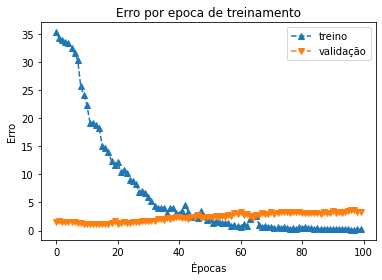

In [22]:
plt.figure(figsize=(6, 4))
plt.plot(loss, label='treino', linestyle='dashed', marker='^')
plt.plot(val_loss, label='validação', linestyle='dashed', marker='v')
plt.legend()
plt.title("Erro por epoca de treinamento")
plt.xlabel("Épocas")
plt.ylabel("Erro")

Text(0, 0.5, 'Acurácia (%)')

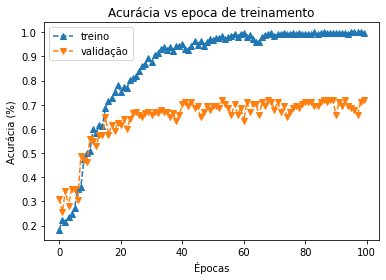

In [23]:
plt.figure(figsize=(6, 4))
plt.plot(acc, label='treino', linestyle='dashed', marker='^')
plt.plot(val_acc, label='validação', linestyle='dashed', marker='v')
plt.legend()
plt.title("Acurácia vs epoca de treinamento")
plt.xlabel("Épocas")
plt.ylabel("Acurácia (%)")

In [24]:

predictions = torch.tensor([]).to(device)
ground_truth = torch.tensor([]).to(device)
for batch in test_loader:
    data, targets = batch[0], batch[1] # next(iter(test_loader))
    data = Variable(torch.Tensor(data.float())).to(device)
    targets = Variable(torch.Tensor(targets.float())).to(device)
    output = model(data)
    loss = criterion(output, torch.flatten(targets.long()))

predictions = torch.cat((predictions, output), 0)
ground_truth = torch.cat((ground_truth, targets), 0)

In [25]:
predictions = predictions.cpu().detach().numpy()
predictions = np.argmax(predictions, axis=1).reshape(predictions.shape[0], 1)
ground_truth = ground_truth.cpu().cpu().detach().numpy()

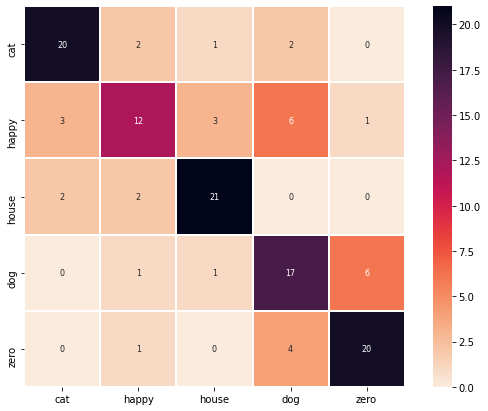

In [26]:
conf_mtx = confusion_matrix(ground_truth, predictions)

conf_df = pd.DataFrame(conf_mtx, index = [i for i in range(5)],
                  columns = [i for i in range(5)])
plt.figure(figsize = (10,7))

labels = [name[2:-4] for name in listdir(feat_dir+'/train')]
sns.heatmap(conf_df, cmap=sns.cm.rocket_r, square=True, 
            linewidths=0.1, annot=True, fmt='d', annot_kws={"fontsize": 8},
           xticklabels=labels, yticklabels=labels)  
plt.show()

In [27]:
acc = accuracy_score(ground_truth, predictions)
print(f' Acc:\t {acc:.3f}')

 Acc:	 0.720
